In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(
    host ="localhost",
    username = "root",
    password="Mysql0707**",
    database ="ecommerce"
)

cur=db.cursor()

# List all unique cities where customers are located.

In [3]:
query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data, columns=["Cities"])
df.head()

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [19]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data, columns=["Total_sales in 2017"])
df

,Total_sales in 2017
0,45101


# Find the total sales per category.

In [5]:
query = """select products.product_category as category,round(sum(payments.payment_value),2) as sales from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category; """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Category","Sales"])
df.head()

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33


#  Calculate the percentage of orders that were paid in installments.



In [30]:
query = """select sum(case when payment_installments >=1 then 1 else 0 end)/ count(*) *100 from payments """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Total_%"])
df

,Total_%
0,99.9981


# Count the number of customers from each state. 

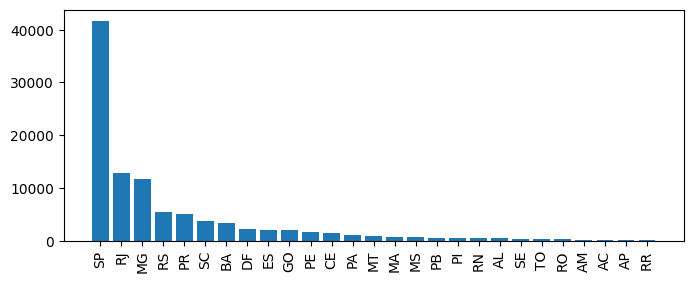

In [7]:
query = """select customer_state, count(customer_id) from customers group by customer_state""" 
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["State","Total_Customer"])
df=df.sort_values(by="Total_Customer",ascending=False)
plt.figure(figsize =(8,3))
plt.bar(df["State"], df["Total_Customer"])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

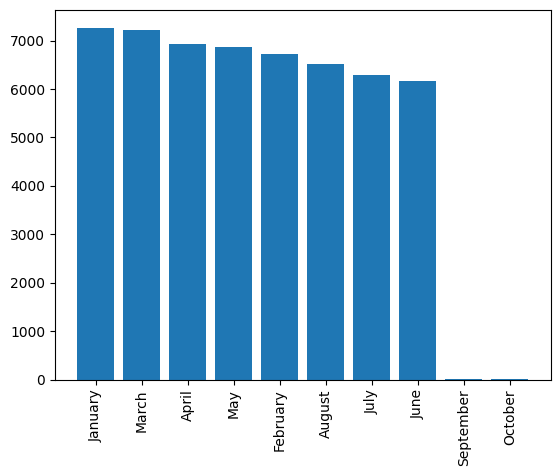

In [52]:
query = """select monthname(order_purchase_timestamp) month,count(order_id) from orders where year(order_purchase_timestamp) =2018
group by month"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Month","Total_orders"])
df=df.sort_values(by="Total_orders", ascending = False )
plt.bar(df["Month"],df["Total_orders"])
plt.xticks(rotation=90)
plt.show()

# Find the average number of products per order, grouped by customer city.


In [8]:
query="""
with count_per_order as
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc 
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id 
group by  customers.customer_city order by average_order desc """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["City","Average_product_order"])
df.head()



,City,Average_product_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


# Calculate the percentage of total revenue contributed by each product category.

In [13]:
query = """ select upper(products.product_category),round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales_percentage
 from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by products.product_category
order by sales_percentage desc """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Category','Percentage_Distribution'])
df.head()

,Category,Percentage_Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product and the number of times a product has been purchased.

In [22]:
query="""select products.product_category ,count( order_items.product_id) as Total_order,
round(avg(order_items.price),2) as Average_price
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=['Category','Total_order','Average_price'])


arr1=df["Total_order"]
arr2=df["Average_price"]
a=np.corrcoef([arr1,arr2])
print("The correlation between product and the number of times a product has been purchased is:",a[0][1])

The correlation between product and the number of times a product has been purchased is: -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [24]:
query = """select *, dense_rank() over(order by revenue desc) from
(select order_items.seller_id,round(sum(payments.payment_value),2) as revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Seller','Revenue','Rank'])
df.head()

,Seller,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# Calculte the moving average of ordrer values for each customer over their order history.

In [25]:
query = """select customer_id,order_purchase_timestamp, avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id)as a """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Customer','Timestamp','Moving_average'])
df.head()

,Customer,Timestamp,Moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002


# Calculate the cumulative sales per month for each year.

In [27]:
query = """ select years,months,payment,sum(payment) 
over(order by years,months) as Cumulative_Sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years, months
order by years,months) as a """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Months','Payment','Cumulative_Sales'])
df.head()

,Years,Months,Payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales.

In [28]:
query = """with a as(select year(orders.order_purchase_timestamp)as years, sum(payments.payment_value) as payment
from payments join orders
on orders.order_id=payments.order_id
group by years order by years)
select years, ((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years)) * 100 as year_over_year from a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Year-over-year'])
df.head()

,Years,Year-over-year
0,2016,NaN
1,2017,12112.703760
2,2018,20.000924


# Calculate the retantion rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [29]:
query="""with
a as (select  customers.customer_id, min(orders.order_purchase_timestamp)as first_order from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) as next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct  a.customer_id)/ count(distinct b.customer_id)) as Retantion_rate
from a left join b
on a.customer_id=b.customer_id """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Retantion_rate'])
df

,Retantion_rate
0,None


# Identify the top 3 customers who spent the most money in each year.

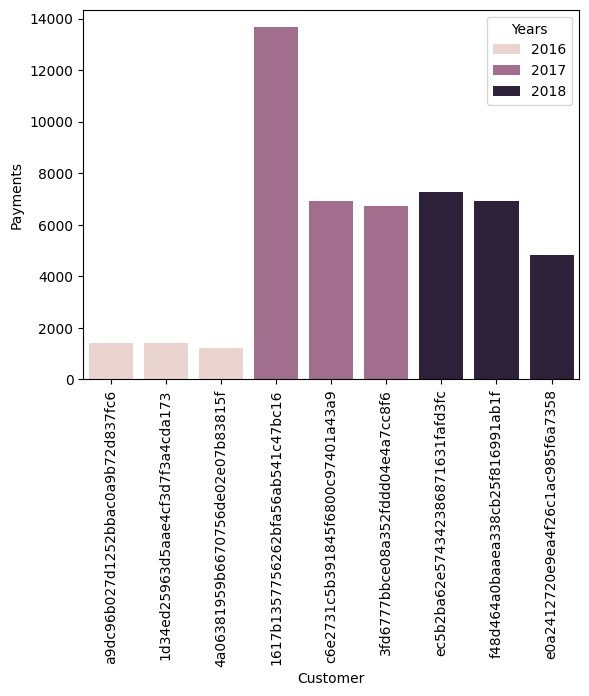

In [33]:
query = """ # Identify the top 3 customers who spent the most money in each year.
select years,customer_id,round(payment,2),d_rank
from 
(select year(orders.order_purchase_timestamp) as years,orders.customer_id,sum(payments.payment_value) as payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id=payments.order_id
group by  year(orders.order_purchase_timestamp),
orders.customer_id)as a
where d_rank <=3
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Years','Customer','Payments','Rank'])
sns.barplot(x='Customer', y='Payments',data=df,hue='Years')
plt.xticks(rotation=90)
plt.show()